In [71]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib
import scipy.optimize as sp
import scipy.signal as sig

In [72]:
base_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/jiaxiang_data/"
calib_path = ["20230915/Impulse_calibration/Dx-0.3",]
noise_path = ["20230912/Dx-0.3/noise/3",]

file_label= '20230915'

In [73]:
## make a list of all the calibration files and sort by impulse size
calib_file_dict = {}
for curr_path in calib_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "**/*.h5"), recursive=True))

    for file in curr_file_list:
        impulse_amp = bu.parse_impulse_amplitude(file)
        if impulse_amp in calib_file_dict.keys():
            calib_file_dict[impulse_amp].append(file)
        else:
            calib_file_dict[impulse_amp] = [file,]

noise_file_list = []
for curr_path in noise_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5"), recursive=True))
    if(len(noise_file_list)>0):
        noise_file_list.append(curr_file_list)
    else:
        noise_file_list = curr_file_list

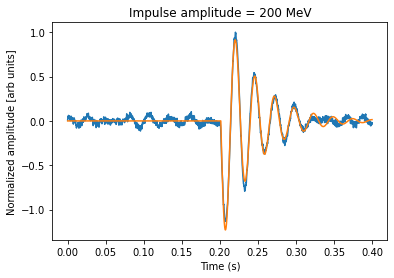

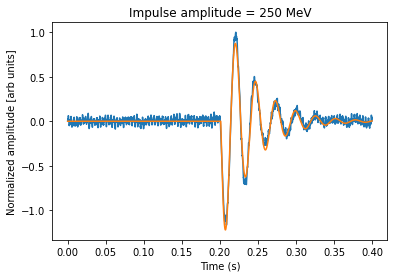

In [74]:
# calculate the pulse tempates by averaging all calibration files
importlib.reload(bu)
template_dict, template_dict_fit, fit_vals = bu.get_average_template(calib_file_dict, make_plots=True, fit_pars=[-1,2*np.pi*30,10,0.20])

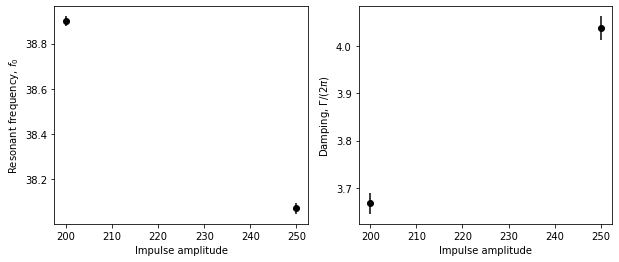

In [75]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.errorbar(fit_vals[:,0], fit_vals[:,1]/(2*np.pi), yerr=fit_vals[:,2]/(2*np.pi), fmt='ko')
plt.xlabel("Impulse amplitude")
plt.ylabel("Resonant frequency, $f_0$")

plt.subplot(1,2,2)
plt.errorbar(fit_vals[:,0], fit_vals[:,3]/(2*np.pi), yerr=fit_vals[:,4]/(2*np.pi), fmt='ko')
plt.xlabel("Impulse amplitude")
plt.ylabel("Damping, $\Gamma/(2\pi)$")

plt.show()

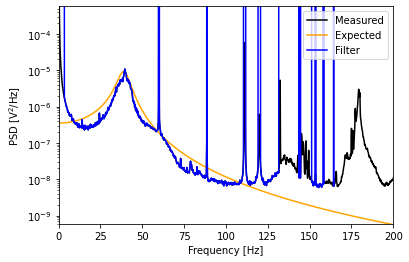

In [76]:
## we don't have noise for this sphere, but assume the old sphere was close enough

importlib.reload(bu)
res_pars = [np.median(fit_vals[:,1]), np.median(fit_vals[:,3])]
noise_dict = bu.get_noise_template(noise_file_list, res_pars=res_pars, nfft=2**16)

In [77]:
importlib.reload(bu)
opt_filt_amps = bu.optimal_filt(calib_file_dict, template_dict_fit, noise_dict, time_offset=-12, make_plots=False)

In [78]:
importlib.reload(bu)
time_corr_amps = bu.correlation_filt(calib_file_dict, template_dict_fit, bandpass=[5,70], notch_list = [], make_plots=False)
## 5, 70, toffset=80, calfac = 8000
bandpass_amps = bu.bandpass_filt(calib_file_dict, template_dict_fit, time_offset=80, bandpass=[5,70], make_plots=False)

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:648: RuntimeWarning: invalid value encountered in sqrt
  bcorr, acorr = sp.butter(3,f0/(5*nyquist), btype='lowpass')


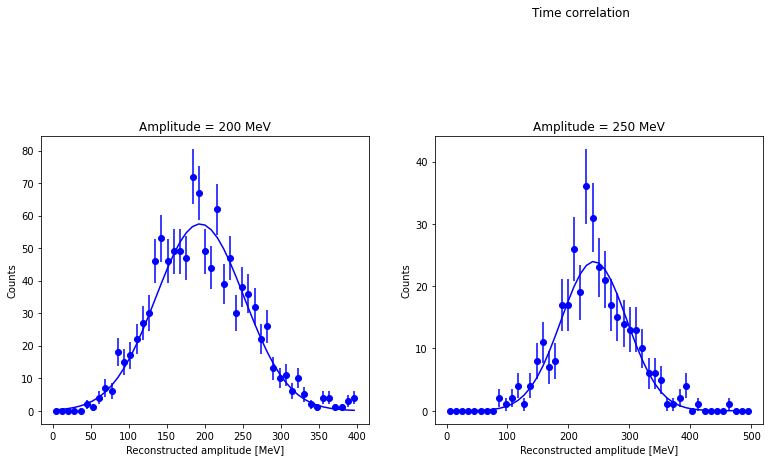

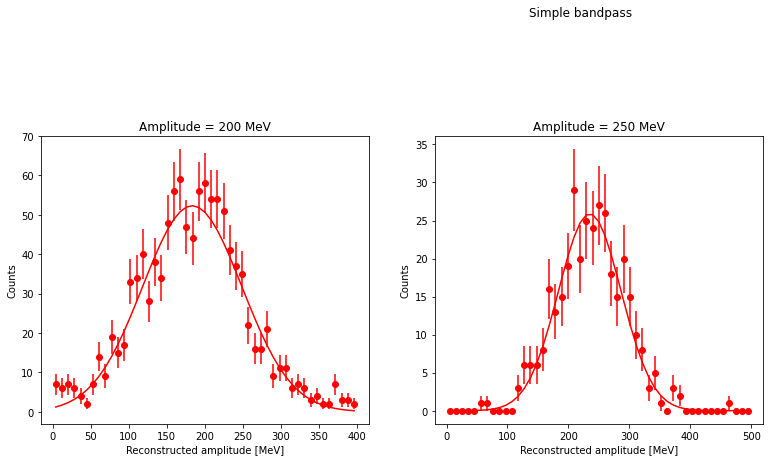

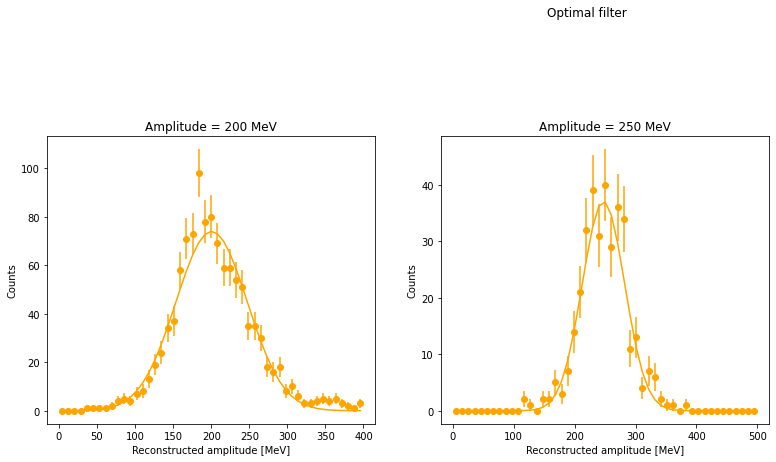

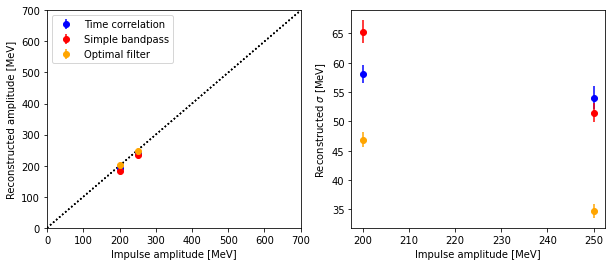

In [79]:
amp_bins = np.arange(0,100,2)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals = []

#print(np.median(opt_filt_amps[600.0]))

#220
amp_dicts = [time_corr_amps, bandpass_amps, opt_filt_amps]
amp_methods = ["Time correlation", "Simple bandpass", "Optimal filter"]
amp_cal_facs = [75, 8500, 230]
amp_colors = ['b', 'r', 'orange']

for i,filt_amps in enumerate(amp_dicts):
    
    plt.figure(figsize=(20,18))
    for j,amp in enumerate(filt_amps.keys()):
        amp_bins = np.linspace(0,2*amp,50)
        hh,be = np.histogram(filt_amps[amp]*amp_cal_facs[i], bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = sp.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

        plt.subplot(3,3,j+1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i], label=amp)
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1fMeV"%(gp[1], gp[2]))
        plt.title("Amplitude = %d MeV"%amp)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed amplitude [MeV]")
        plt.suptitle(amp_methods[i])
        #plt.legend()
    plt.savefig("reconstructed_amplitudes_%s_%s.png"%(amp_methods[i], file_label), dpi=300)

fit_vals = np.array(fit_vals)

plt.figure(figsize=(10,4))

for i in range(len(amp_methods)):

    gpts = fit_vals[:,-1] == i
    plt.subplot(1,2,1)
    plt.errorbar(fit_vals[gpts,0], fit_vals[gpts,1], yerr=fit_vals[gpts,2], fmt='o', color=amp_colors[i], label=amp_methods[i])
    xmin, xmax = 0, 700
    plt.plot([xmin, xmax], [xmin, xmax], 'k:')
    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    plt.xlabel("Impulse amplitude [MeV]")
    plt.ylabel("Reconstructed amplitude [MeV]")
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.errorbar(fit_vals[gpts,0], fit_vals[gpts,3], yerr=fit_vals[gpts,4], fmt='o', color=amp_colors[i])
    plt.xlabel("Impulse amplitude [MeV]")
    plt.ylabel("Reconstructed $\sigma$ [MeV]")


plt.savefig("recon_resolution_%s.png"%file_label, dpi=300)

plt.show()

So everything looks good with the calibraiton for this sphere, and the optimal fitler is again finding resolution ~35 MeV at 250 MeV. Now apply exactly the same analysis to the data with the stepped electric field

In [80]:
step_no_pulse_path = ["20230915/Electric_field_step/Without_Impulse",]
step_with_pulse_path = ["20230915/Electric_field_step+impulse/With_impulse",]

In [81]:
## make a list of all the calibration files and sort by impulse size
step_no_pulse_dict = bu.assemble_file_dict(step_no_pulse_path, base_path, dict_to_use={})
step_with_pulse_dict = bu.assemble_file_dict(step_with_pulse_path, base_path, dict_to_use={})

In [82]:
importlib.reload(bu)
opt_filt_amps = bu.optimal_filt(step_no_pulse_dict, template_dict_fit, noise_dict, time_offset=-12, pulse_data=False, make_plots=False)
time_corr_amps = bu.correlation_filt(step_no_pulse_dict, template_dict_fit, bandpass=[5,70], notch_list = [], time_offset=0, pulse_data=False, make_plots=False)
bandpass_amps = bu.bandpass_filt(step_no_pulse_dict, template_dict_fit, time_offset=80, bandpass=[5,70], pulse_data=False, make_plots=False)

## do the same but not at the step time for comparison
noise_offset = -5000
opt_filt_noise = bu.optimal_filt(step_no_pulse_dict, template_dict_fit, noise_dict, time_offset=noise_offset, pulse_data=False, make_plots=False)
time_corr_noise = bu.correlation_filt(step_no_pulse_dict, template_dict_fit, bandpass=[5,70], notch_list = [], time_offset=noise_offset, pulse_data=False, make_plots=False)
bandpass_noise = bu.bandpass_filt(step_no_pulse_dict, template_dict_fit, time_offset=noise_offset, bandpass=[5,70], pulse_data=False, make_plots=False)

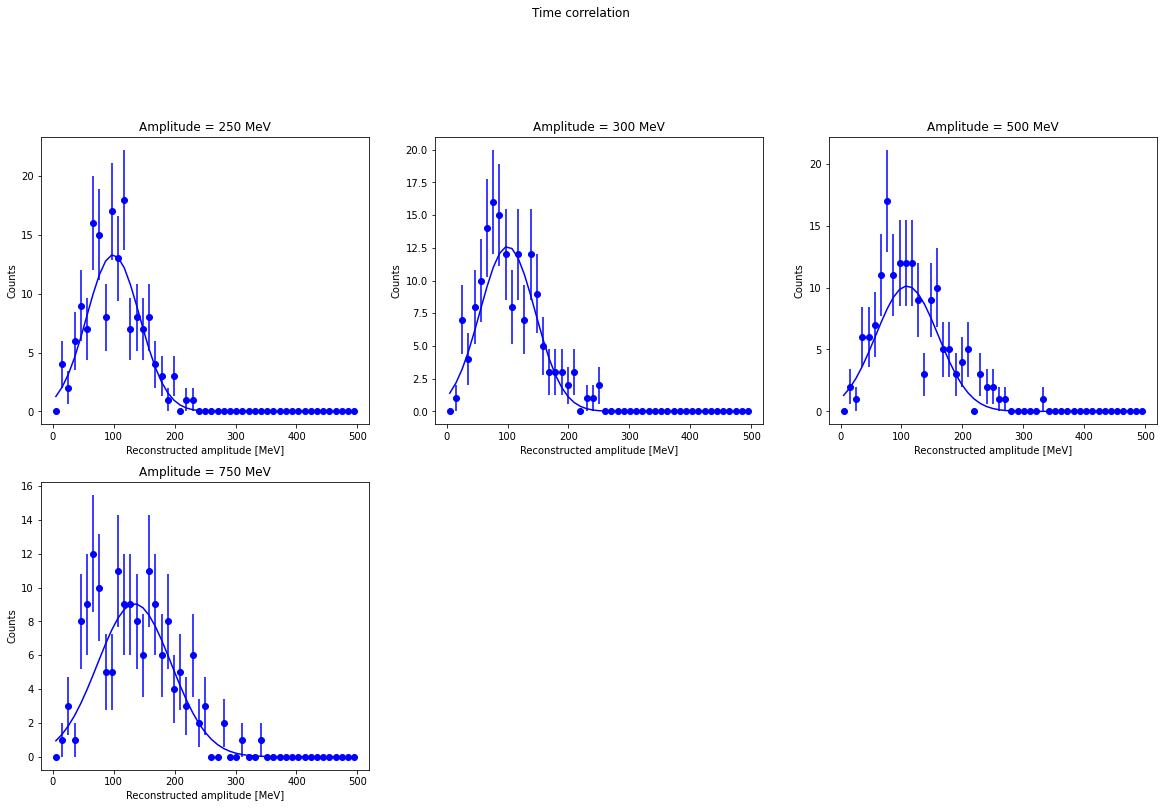

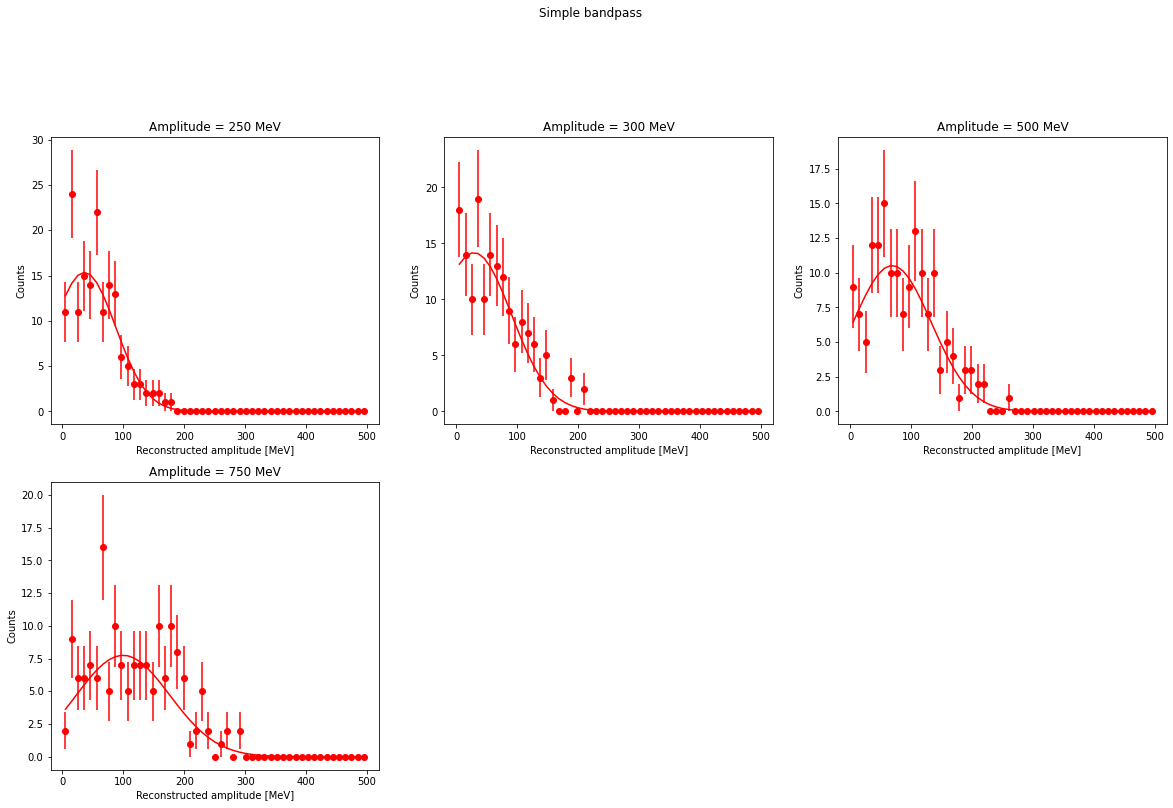

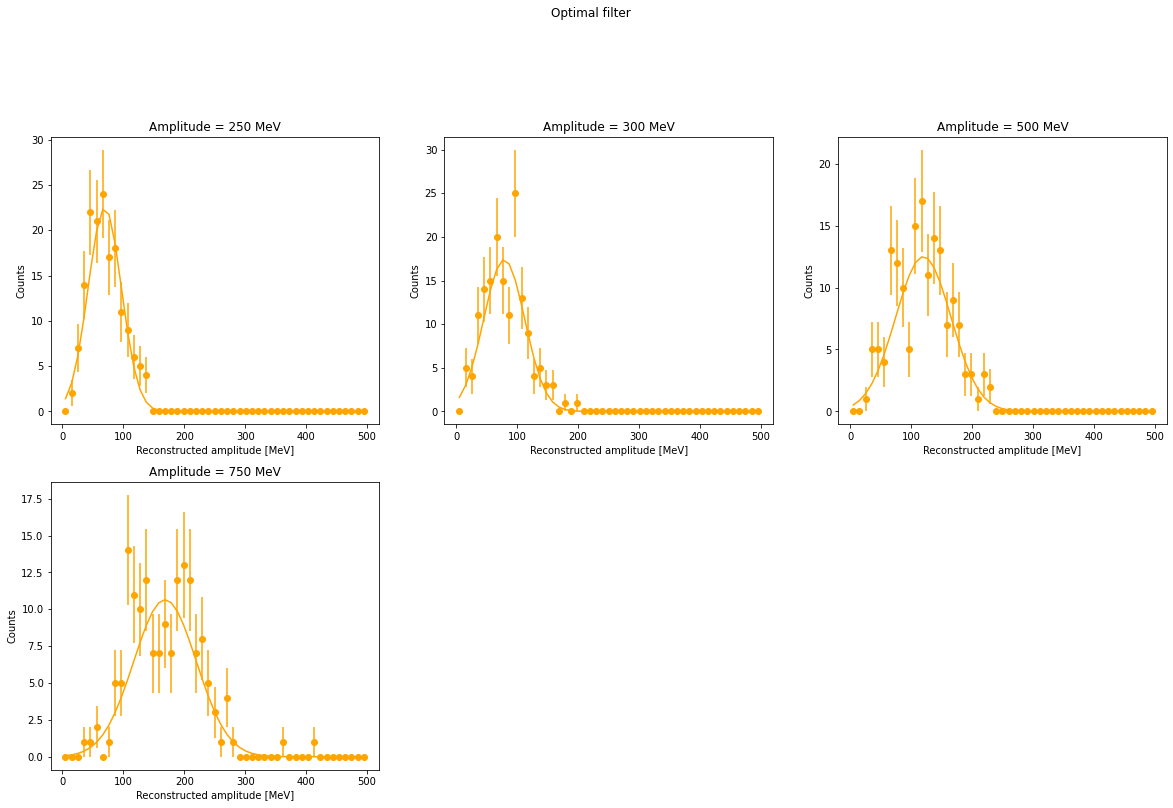

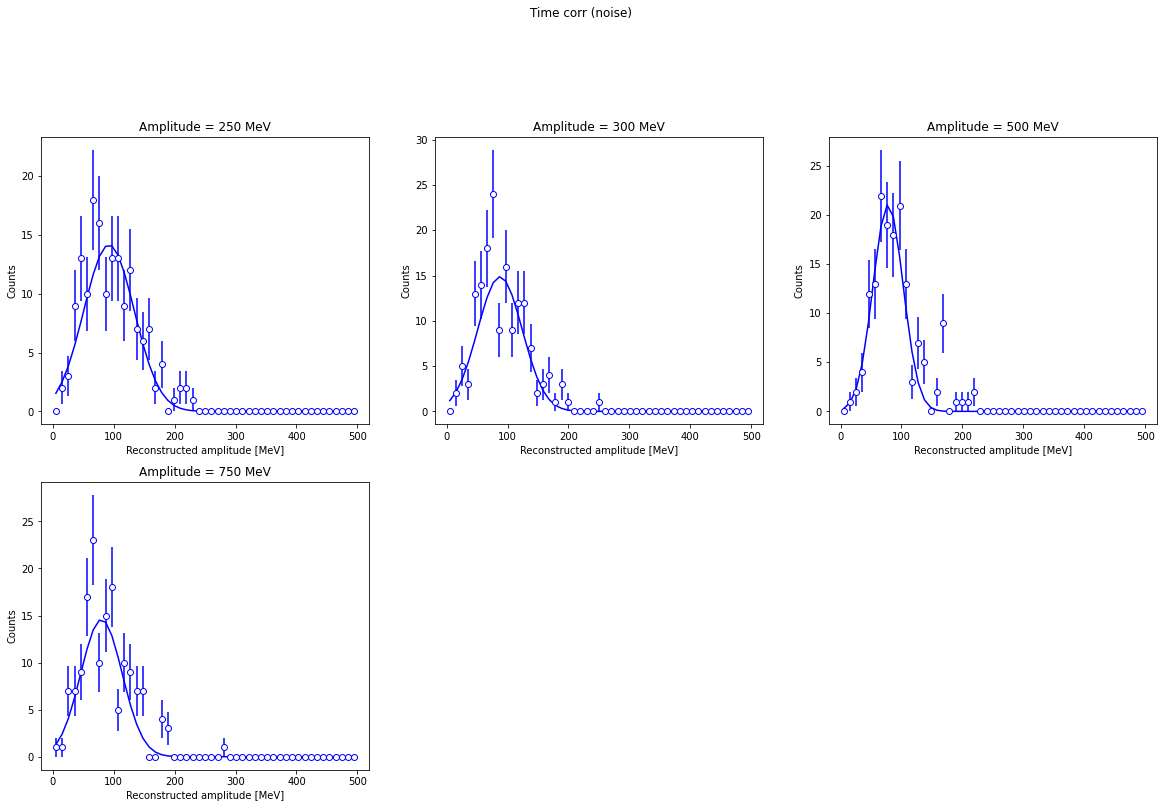

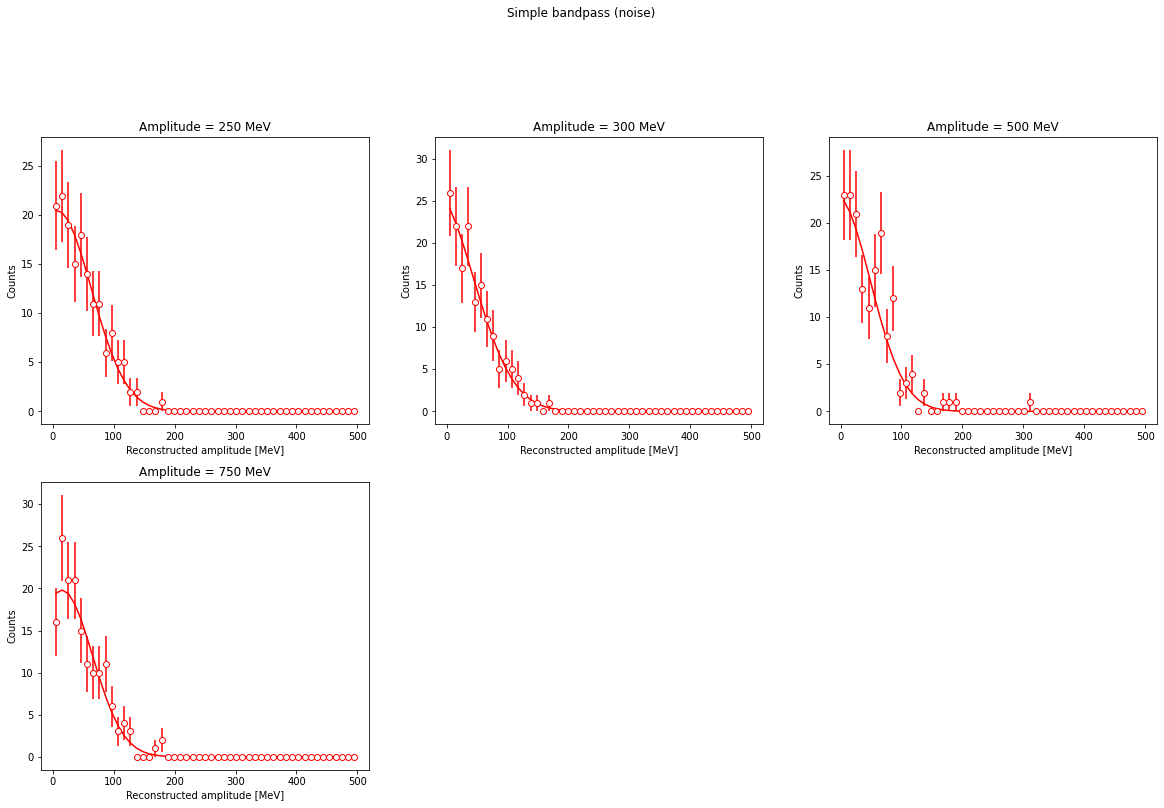

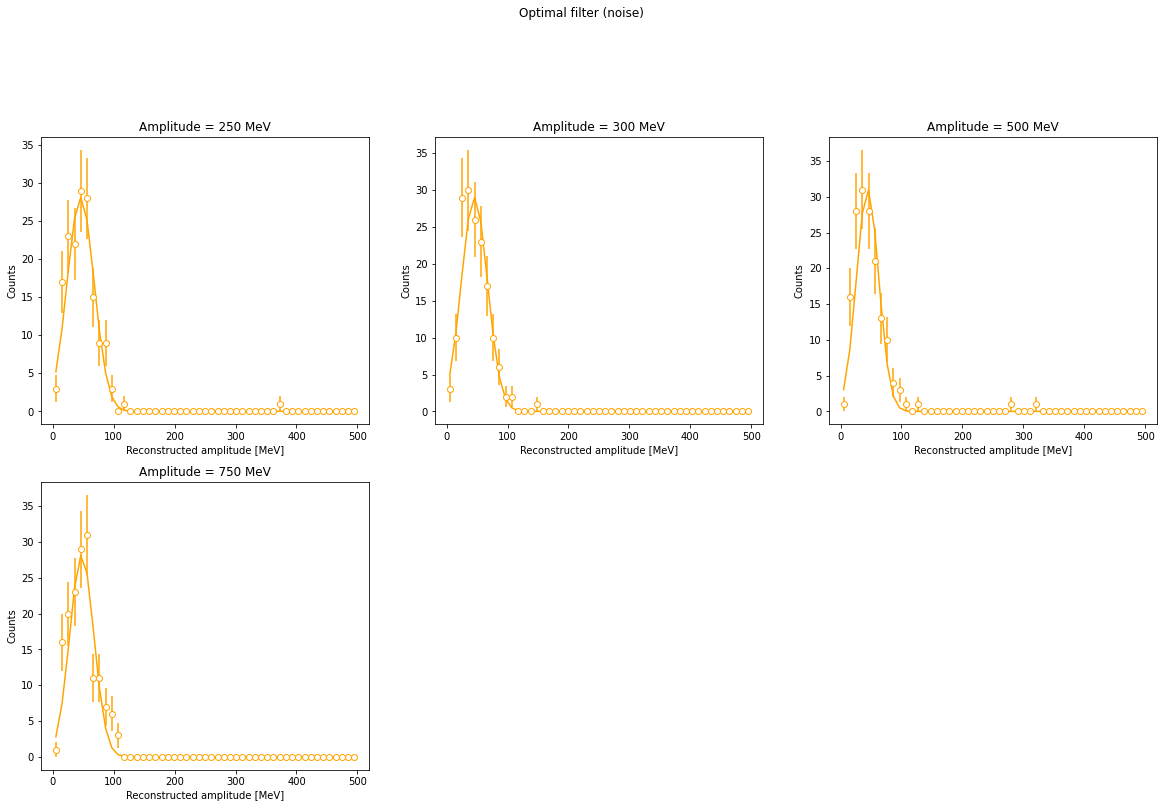

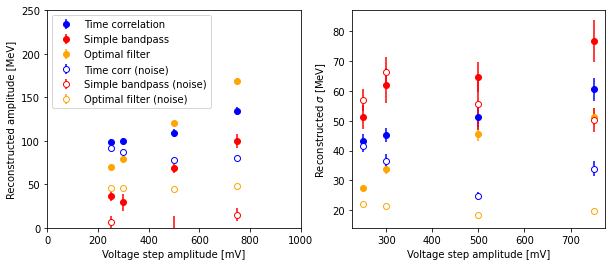

In [88]:
amp_bins = np.arange(0,100,2)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals = []

amp_dicts = [time_corr_amps, bandpass_amps, opt_filt_amps, time_corr_noise, bandpass_noise, opt_filt_noise]
amp_methods = ["Time correlation", "Simple bandpass", "Optimal filter", "Time corr (noise)", "Simple bandpass (noise)", "Optimal filter (noise)"]
amp_cal_facs = [75, 8500, 230, 75, 8500, 230]
amp_colors = ['b', 'r', 'orange', 'b', 'r', 'orange']
face_colors = ['b', 'r', 'orange', 'white', 'white', 'white']

for i,filt_amps in enumerate(amp_dicts):
    
    plt.figure(figsize=(20,18))
    for j,amp in enumerate(filt_amps.keys()):
        amp_bins = np.linspace(0,500,50)
        hh,be = np.histogram(filt_amps[amp]*amp_cal_facs[i], bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        xvals = filt_amps[amp]*amp_cal_facs[i]
        spars = [1, np.median(xvals[~np.isnan(xvals)]), 50]
        gp, gcov = sp.curve_fit(gauss_fun, bc, hh, sigma=err, p0=spars)

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

        plt.subplot(3,3,j+1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i], label=amp, mfc=face_colors[i])
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1fMeV"%(gp[1], gp[2]))
        #plt.plot(bc, gauss_fun(bc, *spars), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1fMeV"%(gp[1], gp[2]))
        plt.title("Amplitude = %d MeV"%amp)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed amplitude [MeV]")
        plt.suptitle(amp_methods[i])
        #plt.legend()
    plt.savefig("reconstructed_amplitudes_step_only_%s_%s.png"%(amp_methods[i], file_label), dpi=300)

fit_vals = np.array(fit_vals)

plt.figure(figsize=(10,4))

for i in range( len(amp_methods) ):

    gpts = fit_vals[:,-1] == i
    plt.subplot(1,2,1)
    plt.errorbar(fit_vals[gpts,0], fit_vals[gpts,1], yerr=fit_vals[gpts,2], fmt='o', color=amp_colors[i], label=amp_methods[i], mfc=face_colors[i])
    xmin, xmax = 0, 1000
    #plt.plot([xmin, xmax], [xmin, xmax], 'k:')
    plt.xlim(xmin, xmax)
    plt.ylim(xmin, 250)
    plt.xlabel("Voltage step amplitude [mV]")
    plt.ylabel("Reconstructed amplitude [MeV]")
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.errorbar(fit_vals[gpts,0], fit_vals[gpts,3], yerr=fit_vals[gpts,4], fmt='o', color=amp_colors[i], mfc=face_colors[i])
    plt.xlabel("Voltage step amplitude [mV]")
    plt.ylabel("Reconstructed $\sigma$ [MeV]")


plt.savefig("recon_resolution_step_only_%s.png"%file_label, dpi=300)

plt.show()

Things look roughly ok for the 250mV voltage step above, but there is still a bit of an increase in the reconstructed amplitude compared to the noise only case even at 250 mV, and this grows with the step amplitude. It won't confuse us very much for a 200-250 MeV impulse and is ok if we need to live with this, 
but it is better to eliminate this systematic if possible by using amplitudes a bit less than 250 mV or better analysis.

Once simple better analysis is to subtract off the expected impulse from the waveform: